In [1]:
import numpy as np
from numpy import sin, cos, sqrt, arctan2, deg2rad, rad2deg, sqrt
import matplotlib.pyplot as plt

In [2]:
def compute_transition(accel, gamma):
    # constants
    g = 9.8              # acceleration of gravity, m/s^2
    
    # rough dimensions of cessna 172
    m = 1000  # mass, kg
    s = 16  # wing area, m^2
    
    # aerodynamics
    CL_max = 1.2  # max CL
    CD = 0.01 + 0.1*CL_max**2 # CD estimate
    rho = 1.225  # density of air
    alpha = deg2rad(15)  # angle of attack at CL_max, rad

    # compute v stall
    W = m*g
    theta = alpha + gamma
    V_stall = sqrt(2*W/(rho*s*CL_max))
    
    # compute transition time
    t_transition = V_stall/accel  # time to transition
    t = np.linspace(0, 0.999*t_transition, 1000)

    # accelerations, assumes we maintain flight path angle, so accel in direction of velocity
    a = np.where(t < t_transition, accel, 0)
    xdd = a*cos(gamma)
    zdd = a*sin(gamma)
    
    # compute aero forces
    V = np.where(t < t_transition, accel*t, V_stall)
    q = 0.5*rho*V**2
    L = CL_max*q*s
    D = CD*q*s

    # compute thrust
    Tx = m*xdd + L*sin(gamma) + D*cos(gamma)
    Tz = m*zdd - L*cos(gamma) + W + D*sin(gamma)
    
    delta = arctan2(Tz, Tx)
    T = sqrt(Tx**2 + Tz**2)

    # estimate fuel consumption and power
    adjust = 1/71.16650358139003  # set so P=D*V for steady level flight, should try to justify
    fuel_energy_density = adjust*42.8e6 # J/kg, aviation jet fuel
    efficiency = 1
    tsfc = 48*1e-6 # kg/(N-s) https://en.wikipedia.org/wiki/Thrust-specific_fuel_consumption
    m_dot = tsfc*T
    P = m_dot*fuel_energy_density/efficiency
    return locals()

In [3]:
def plot_transition_corridor(gamma_deg, accel_g_list):
    data = {}
    for accel_g in accel_g_list:
        res = compute_transition(accel=accel_g*9.8, gamma=deg2rad(gamma_deg))
        data[accel_g] = res

        label = 'gamma={:g} deg, accel={:g} g'.format(gamma_deg, accel_g)                                  
        plt.figure(1, figsize=(15, 10))
        plt.title('Transition Corridor, Thrust Angle from Horizon')
        p = plt.plot(res['V'], np.rad2deg(res['delta']), label=label)
        plt.xlabel('V, m/s')
        plt.ylabel('Thrust Angle from Horizon, deg')
        plt.legend()
        plt.grid(True)

        plt.figure(2, figsize=(15, 10))
        p = plt.plot(res['V'], res['T'], label=label)
        plt.title('Transition Corridor, Thrust Magnitude')
        plt.xlabel('V, m/s')
        plt.ylabel('Thrust, N')
        plt.legend()
        plt.grid(True)
    return data

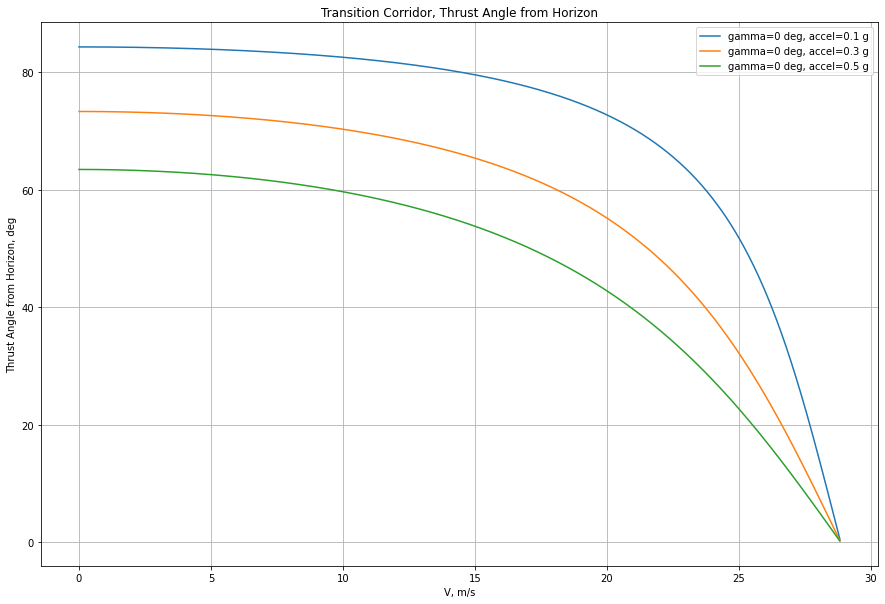

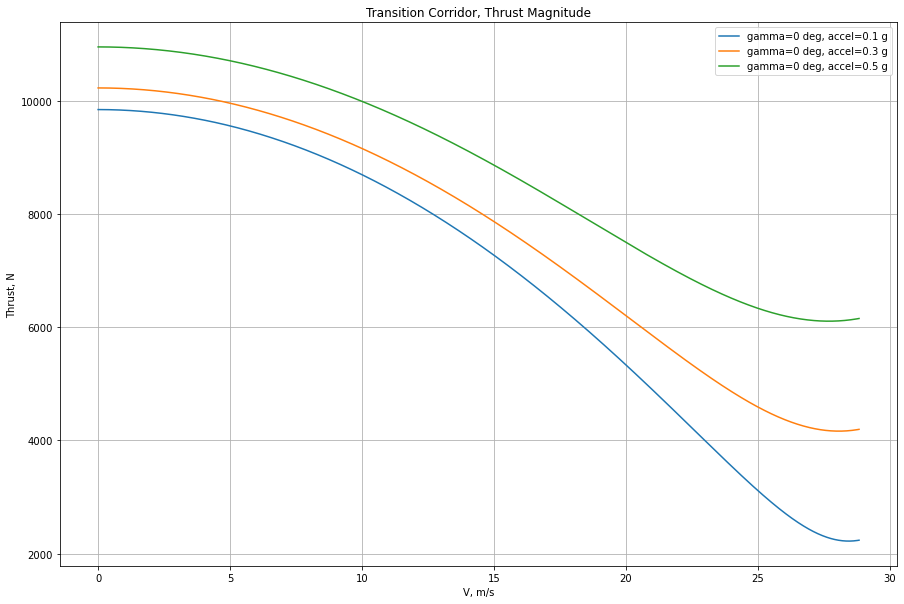

In [4]:
res = plot_transition_corridor(gamma_deg=0, accel_g_list=[0.1, 0.3, 0.5]);

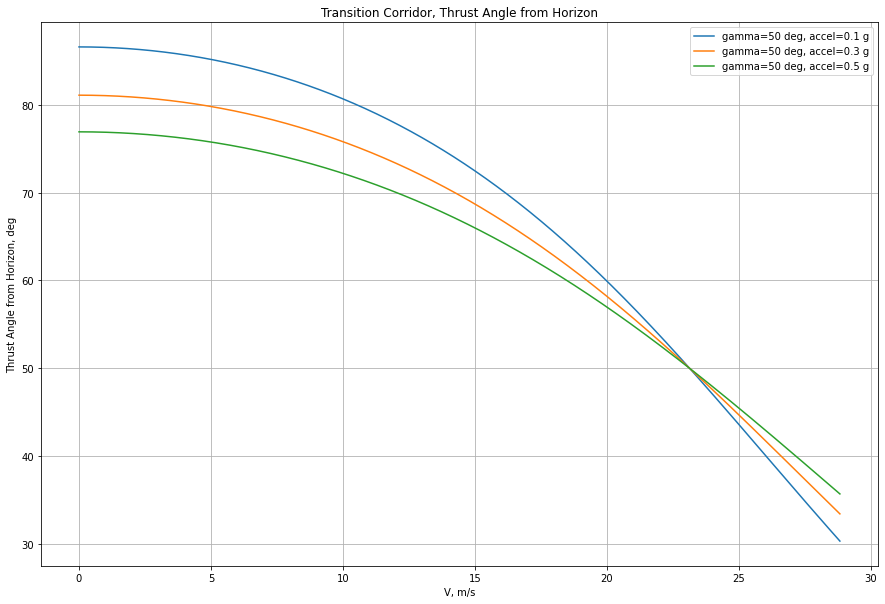

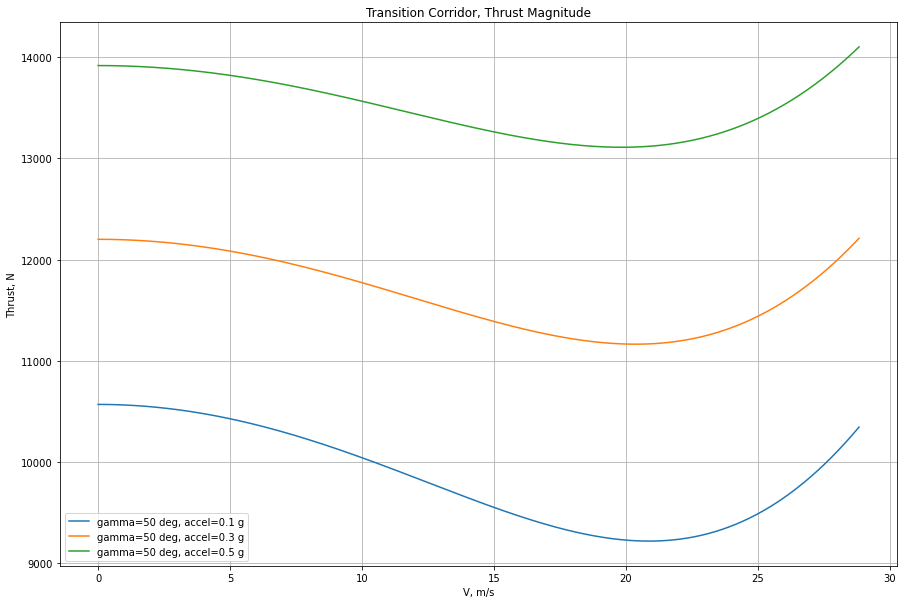

In [5]:
res = plot_transition_corridor(gamma_deg=50, accel_g_list=[0.1, 0.3, 0.5]);